<a href="https://colab.research.google.com/github/oimartin/MNIST_Digit_Recognizer/blob/main/digits_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ingest

In [1]:
# !pip install yellowbrick

In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from yellowbrick.classifier import ClassificationReport, ConfusionMatrix, ROCAUC, ClassPredictionError
from yellowbrick.style import set_palette

%matplotlib inline

# Data Preprocessing
from sklearn.model_selection import train_test_split

# Models
from time import time
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans

# Model Fit Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

from sklearn.metrics import roc_curve

## First View of Data

In [3]:
train = pd.read_csv('https://raw.githubusercontent.com/oimartin/MNIST_Digit_Recognizer/main/data/train.zip')
test = pd.read_csv('https://raw.githubusercontent.com/oimartin/MNIST_Digit_Recognizer/main/data/test.zip')

display(train.shape, test.shape)

(42000, 785)

(28000, 784)

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [5]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# EDA

### Explore Label Column

In [6]:
train.label.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

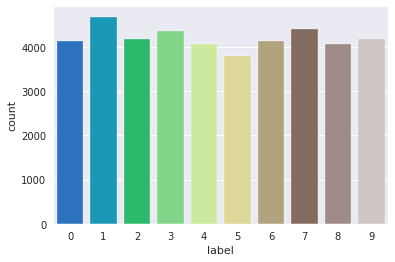

In [7]:
sns.set_style("darkgrid")
sns.countplot(data=train, x='label', palette='terrain')

### Missing Values

In [8]:
def null_sum (df):
  # double check for missing values
  nulls = df.isnull().sum()
  return nulls[nulls >=1]

In [9]:
null_sum(train)

Series([], dtype: int64)

In [10]:
null_sum(test)

Series([], dtype: int64)

## Split Data

In [11]:
def split_data (data_frame):

# Create subset of train data to run faster
# Subset code inspired by Ben Hamner https://www.kaggle.com/benhamner/rf-proximity
  mini_df = data_frame.iloc[:1000, :]
  labels = mini_df.label.astype('category')
  mini_df = mini_df.drop(columns='label')

  X_train, X_test, labels_train, labels_test = train_test_split(mini_df,
                                                                labels,
                                                                test_size=0.2,
                                                                random_state=22)

  print(f'''X_train shape {X_train.shape}
labels_train shape {labels_train.shape}
X_test shape {X_test.shape}
labels_test {labels_test.shape}
''')
  return  X_train, X_test, labels_train, labels_test

In [12]:
X_train, X_test, labels_train, labels_test = split_data(train)

X_train shape (800, 784)
labels_train shape (800,)
X_test shape (200, 784)
labels_test (200,)



# Model

## Model Functions

In [73]:
def run_model (model, model_name, x_data, y_data, gridcv=False,params=None):
  if gridcv is True:
    clf = GridSearchCV(model,params)
    start = time()
    fitted_model = clf.fit(x_data, y_data)
    end = time()
    runtime = round((end - start),4)
    print(f"{model_name} took {runtime} seconds or {round((runtime/60),4)} minutes to run.")

  elif gridcv is False:
    start = time()
    fitted_model = model.fit(x_data, y_data)
    end = time()
    runtime = round((end-start), 4)
    print(f"{model_name} took {runtime} seconds or {round((runtime/60),4)} minutes to run.")
  return fitted_model, runtime

def prediction (fitted_model, x_feat):
  pred = fitted_model.predict(x_feat)
  return pred

def probability (fitted_model, x_feat):
  total_prob = fitted_model.predict_proba(x_feat)
  return total_prob

def evaluating_model (y_true, y_pred, model_name, train_test):
  df=pd.DataFrame({ 'model_name': [model_name, model_name, 
                                   model_name, model_name],
                   'type': [train_test, train_test,
                            train_test, train_test],
                   'metric_name': ["accuracy","f1",'recall',
                                   'precision'],
                   'metric' : [round(accuracy_score(y_true, y_pred),4),
                               round(f1_score(y_true, y_pred, average='micro'),4),
                               round(recall_score(y_true, y_pred, average='micro'), 4),
                               round(precision_score(y_true, y_pred, average='micro'), 4)]})
  display(df)
  return df

def prob_eval (y_true, y_prob, model_name, train_test):
  df=pd.DataFrame({ 'model_name': [model_name, model_name],
                   'type': [train_test, train_test],
                   'metric_name': ['log_loss','roc_auc'],
                   'metric' : [round(log_loss(y_true, y_prob), 4),
                               round(roc_auc_score(y_true, y_prob, multi_class='ovo'),4)]})
  display(df)
  return df


def eval_classification (y_pred, y_true, x_data, model_name, train_test):
  fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)
  print(f'''
  {model_name} for {train_test} Data
  FPR {fpr}
  TPR {tpr}
  ''')
  return

def class_vis (model, model_name, x_train, y_train, x_test, y_test):
  sns.set_style("darkgrid")
  set_palette('paired')
  visualizer = ClassificationReport(model, classes=list(y_train.unique()), support=True)
  visualizer.fit(x_train, y_train)        # Fit the visualizer and the model
  visualizer.score(x_test, y_test)        # Evaluate the model on the test data
  visualizer.show(outpath=f"{model_name}_classification_report.png")
  visualizer.show()

  cm = ConfusionMatrix(model, classes=list(y_train.unique()))
  cm.fit(x_train, y_train)
  cm.score(x_test, y_test)
  cm.show(outpath=f"{model_name}_confusin_matrix.png")
  cm.show()

  vis = ROCAUC(model, classes=list(y_train.unique()))
  vis.fit(x_train, y_train)
  vis.score(x_test, y_test)
  vis.show(outpath=f"{model_name}_rocauc.png")
  vis.show()

  graph = ClassPredictionError(model, classes=list(y_train.unique()))
  graph.fit(x_train, y_train)
  graph.score(x_test, y_test)
  graph.show(outpath=f"{model_name}_class_prediction.png")
  graph.show()
  return

def feature_importance (x_data, model):
  df = pd.DataFrame({'feature': x_data.columns, 'feature_importances': model.feature_importances_}).sort_values(by='feature_importances', ascending=False).head(10)
  return df

def submitted (fitted_model, model_name, test=test):
  pred = fitted_model.predict(test)
  df = pd.DataFrame(pred).rename(columns={0: 'Label'}).astype('int64')
  df.index += 1
  df['ImageId'] = df.index
  df.to_csv(f"{model_name}_pred.csv", index=False) 
  return df


## Random Forest Classifier

In [79]:
RFC_model, RFC_rt = run_model(RandomForestClassifier(random_state=22), 'RFC', 
                              X_train, labels_train, False)

train_pred_RFC = prediction(RFC_model, X_train)
train_totprob_RFC = probability(RFC_model, X_train)

test_pred_RFC = prediction(RFC_model, X_test)
test_totprob_RFC = probability(RFC_model, X_test)

RFC took 0.6191 seconds or 0.0103 minutes to run.


### RFC Evaluation

In [81]:
RFC_train = evaluating_model(labels_train, train_pred_RFC, 'RFC', 'Train')
RFC_train_prob = prob_eval(labels_train, train_totprob_RFC, 'RFC', 'Train')
eval_classification(train_pred_RFC, labels_train, X_train, 'RFC', 'Train')

print("---------------------")
RFC_test = evaluating_model(labels_test, test_pred_RFC, 'RFC', 'Test')
RFC_test_prob = prob_eval(labels_test, test_totprob_RFC, 'RFC', 'Test')
eval_classification(test_pred_RFC, labels_test, X_test, 'RFC', 'Test')

,model_name,type,metric_name,metric
0,RFC,Train,accuracy,1.0
1,RFC,Train,f1,1.0
2,RFC,Train,recall,1.0
3,RFC,Train,precision,1.0


,model_name,type,metric_name,metric
0,RFC,Train,log_loss,0.192
1,RFC,Train,roc_auc,1.000



  RFC for Train Data
  FPR [0.         0.11080332 0.20775623 0.32409972 0.43351801 0.53739612
 0.6468144  0.74792244 0.88642659 0.88642659 1.        ]
  TPR [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
  
---------------------


,model_name,type,metric_name,metric
0,RFC,Test,accuracy,0.905
1,RFC,Test,f1,0.905
2,RFC,Test,recall,0.905
3,RFC,Test,precision,0.905


,model_name,type,metric_name,metric
0,RFC,Test,log_loss,0.7283
1,RFC,Test,roc_auc,0.9891



  RFC for Test Data
  FPR [0.         0.09340659 0.20879121 0.31318681 0.3956044  0.46153846
 0.5989011  0.71428571 0.84615385 0.85714286 1.        ]
  TPR [0.         0.05555556 0.05555556 0.05555556 0.05555556 0.05555556
 0.05555556 0.05555556 0.05555556 1.         1.        ]
  


In [82]:
feature_importance(X_train, RFC_model)

,feature,feature_importances
378,pixel378,0.010127
409,pixel409,0.009164
155,pixel155,0.008053
346,pixel346,0.007754
405,pixel405,0.007448
406,pixel406,0.007436
461,pixel461,0.007410
433,pixel433,0.006986
596,pixel596,0.006881
516,pixel516,0.006720


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


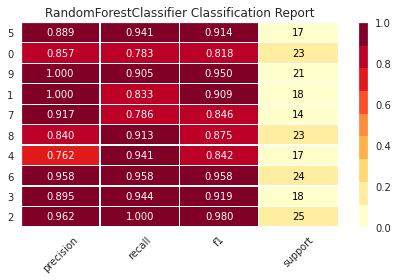

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


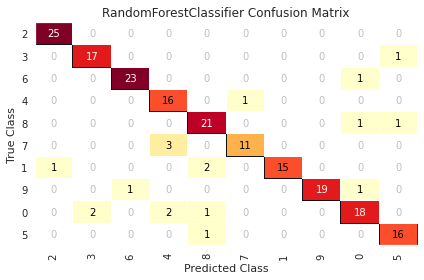

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


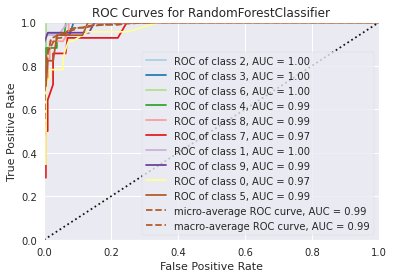

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


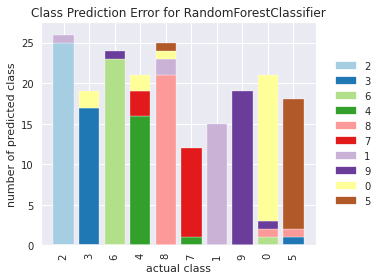

In [83]:
class_vis(RFC_model, 'RFC', X_train, labels_train, 
             X_test, labels_test)

### Actual Test Data Predictions

In [84]:
submitted(RFC_model, 'RFC')

,Label,ImageId
1,2,1
2,0,2
3,9,3
4,7,4
5,2,5
...,...,...
27996,9,27996
27997,7,27997
27998,3,27998
27999,9,27999


## RFC with GridCV

### Run Model

In [75]:
parameters = {'n_estimators':[100,200,400],
              'criterion': ('gini', 'entropy'),
              'min_samples_split': [2,3,4],
              'min_samples_leaf': [1,2,3],
              'random_state': [22]}

RFCcv_model, RFCcv_rt = run_model(RandomForestClassifier(),'RFCcv',
                                  X_train,
                                  labels_train, 
                                  True,
                                  parameters)

train_pred_RFCcv = prediction(RFCcv_model, X_train)
train_totprob_RFCcv = probability(RFCcv_model, X_train)

test_pred_RFCcv = prediction(RFCcv_model, X_test)
test_totprob_RFCcv = probability(RFCcv_model, X_test)

RFCcv took 343.6749 seconds or 5.7279 minutes to run.


In [90]:
RFCcv_model.best_params_

{'criterion': 'gini',
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 200,
 'random_state': 22}

### RFC with GridCV Evaluation

In [85]:
RFCcv_train = evaluating_model(labels_train, train_pred_RFCcv, 'RFCcv', 'Train')
RFCcv_train_prob = prob_eval(labels_train, train_totprob_RFCcv, 'RFCcv', 'Train')
eval_classification(train_pred_RFCcv, labels_train, X_train, 'RFCcv', 'Train')

print("---------------------")
RFCcv_test = evaluating_model(labels_test, test_pred_RFCcv, 'RFCcv', 'Test')
RFCcv_test_prob = prob_eval(labels_test, test_totprob_RFCcv, 'RFCcv', 'Test')
eval_classification(test_pred_RFCcv, labels_test, X_test, 'RFCcv', 'Test')

,model_name,type,metric_name,metric
0,RFCcv,Train,accuracy,1.0
1,RFCcv,Train,f1,1.0
2,RFCcv,Train,recall,1.0
3,RFCcv,Train,precision,1.0


,model_name,type,metric_name,metric
0,RFCcv,Train,log_loss,0.227
1,RFCcv,Train,roc_auc,1.000



  RFCcv for Train Data
  FPR [0.         0.11080332 0.20775623 0.32409972 0.43351801 0.53739612
 0.6468144  0.74792244 0.88642659 0.88642659 1.        ]
  TPR [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
  
---------------------


,model_name,type,metric_name,metric
0,RFCcv,Test,accuracy,0.895
1,RFCcv,Test,f1,0.895
2,RFCcv,Test,recall,0.895
3,RFCcv,Test,precision,0.895


,model_name,type,metric_name,metric
0,RFCcv,Test,log_loss,0.7176
1,RFCcv,Test,roc_auc,0.9908



  RFCcv for Test Data
  FPR [0.         0.10989011 0.21428571 0.32417582 0.41758242 0.47802198
 0.6043956  0.71978022 0.85164835 0.86263736 1.        ]
  TPR [0.         0.05555556 0.05555556 0.05555556 0.05555556 0.05555556
 0.05555556 0.05555556 0.05555556 1.         1.        ]
  


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


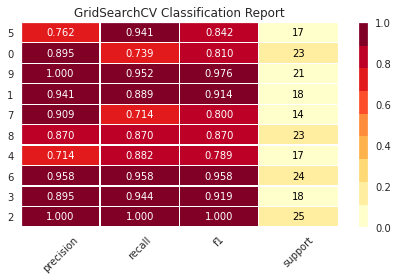

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


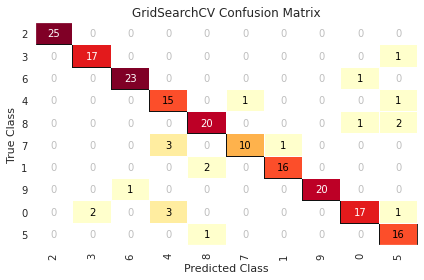

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


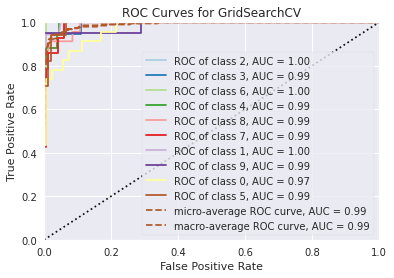

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


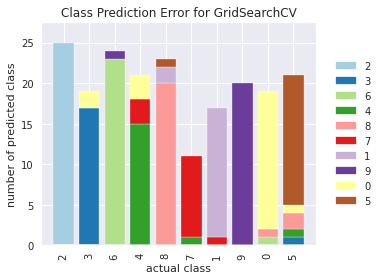

In [87]:
class_vis(RFCcv_model, 'RFCcv', X_train, labels_train, 
             X_test, labels_test)

### Actual Test Data Predictions

In [93]:
submitted(RFCcv_model, 'RFCcv')

,Label,ImageId
1,2,1
2,0,2
3,9,3
4,7,4
5,2,5
...,...,...
27996,9,27996
27997,7,27997
27998,3,27998
27999,9,27999


## Principal Component Analysis

In [94]:
def components_time (model):
    start = time()
    comps = model.components_
    end = time()
    runtime = round((end - start),4)
    print(f"Number of PCA components {len(comps)}, completed in {runtime} seconds or {round((runtime/60),4)} minutes to run.")
    return comps

In [95]:
data = pd.concat([train,test])
data.shape

(70000, 785)

In [96]:
X_train, X_test, labels_train, labels_test = split_data(data)

X_train shape (800, 784)
labels_train shape (800,)
X_test shape (200, 784)
labels_test (200,)



### Run PCA

In [97]:
PCA_model, PCA_rt = run_model(PCA(n_components=0.95, svd_solver='full'), 'PCA', X_train, labels_train, gridcv=False)
PCA_comps = components_time(PCA_model)

PCA took 0.2644 seconds or 0.0044 minutes to run.
Number of PCA components 127, completed in 0.0 seconds or 0.0 minutes to run.


In [98]:
X_train_PCA = PCA_model.transform(X_train)
X_test_PCA = PCA_model.transform(X_test)
test_PCA = PCA_model.transform(test)

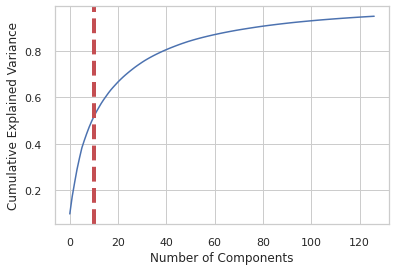

None

,Cumulative Variance Ratio,Explained Variance Ratio
122,0.947688,0.000642
123,0.948321,0.000632
124,0.948944,0.000623
125,0.949555,0.000611
126,0.950158,0.000603


<Figure size 432x288 with 0 Axes>

In [99]:
sns.set(style='whitegrid')

plt.plot(np.cumsum(PCA_model.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

plt.axvline(linewidth=4, color='r', linestyle = '--', x=10, ymin=0, ymax=1)
display(plt.show())

evr = PCA_model.explained_variance_ratio_
cvr = np.cumsum(PCA_model.explained_variance_ratio_)

pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.tail())
plt.savefig("no_components_cumul_expl_var.png")

## Random Forest Classifier with PCA Components

In [100]:
RFC_PCA_model, RFC_PCA_rt = run_model(RandomForestClassifier(), 'RFC_PCA', X_train_PCA, labels_train, False)
train_pred_RFC_PCA = prediction(RFC_PCA_model, X_train_PCA)
train_totprob_RFC_PCA = probability(RFC_PCA_model, X_train_PCA)

test_pred_RFC_PCA = prediction(RFC_PCA_model, X_test_PCA)
test_totprob_RFC_PCA = probability(RFC_PCA_model, X_test_PCA)

RFC_PCA took 0.631 seconds or 0.0105 minutes to run.


### RFC with PCA Evaluation

In [101]:
RFC_PCA_train = evaluating_model(labels_train, train_pred_RFC_PCA, 'RFC_PCA', 'Train')
RFC_PCA_train_prob = prob_eval(labels_train, train_totprob_RFC_PCA, 'RFC_PCA', 'Train')
eval_classification(train_pred_RFC_PCA, labels_train, X_train_PCA, 'RFC_PCA', 'Train')

print("---------------------")
RFC_PCA_test = evaluating_model(labels_test, test_pred_RFC_PCA, 'RFC_PCA', 'Test')
RFC_PCA_test_prob = prob_eval(labels_test, test_totprob_RFC_PCA, 'RFC_PCA', 'Test')
eval_classification(test_pred_RFC, labels_test, X_test_PCA, 'RFC_PCA', 'Test')

,model_name,type,metric_name,metric
0,RFC_PCA,Train,accuracy,1.0
1,RFC_PCA,Train,f1,1.0
2,RFC_PCA,Train,recall,1.0
3,RFC_PCA,Train,precision,1.0


,model_name,type,metric_name,metric
0,RFC_PCA,Train,log_loss,0.2776
1,RFC_PCA,Train,roc_auc,1.0000



  RFC_PCA for Train Data
  FPR [0.         0.11080332 0.20775623 0.32409972 0.43351801 0.53739612
 0.6468144  0.74792244 0.88642659 0.88642659 1.        ]
  TPR [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
  
---------------------


,model_name,type,metric_name,metric
0,RFC_PCA,Test,accuracy,0.845
1,RFC_PCA,Test,f1,0.845
2,RFC_PCA,Test,recall,0.845
3,RFC_PCA,Test,precision,0.845


,model_name,type,metric_name,metric
0,RFC_PCA,Test,log_loss,1.1266
1,RFC_PCA,Test,roc_auc,0.9717



  RFC_PCA for Test Data
  FPR [0.         0.09340659 0.20879121 0.31318681 0.3956044  0.46153846
 0.5989011  0.71428571 0.84615385 0.85714286 1.        ]
  TPR [0.         0.05555556 0.05555556 0.05555556 0.05555556 0.05555556
 0.05555556 0.05555556 0.05555556 1.         1.        ]
  


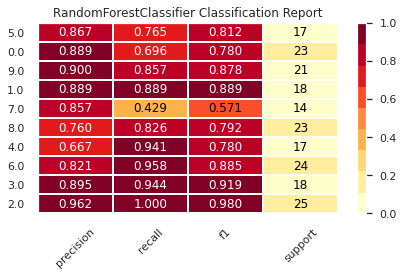

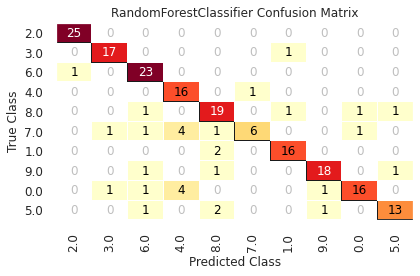

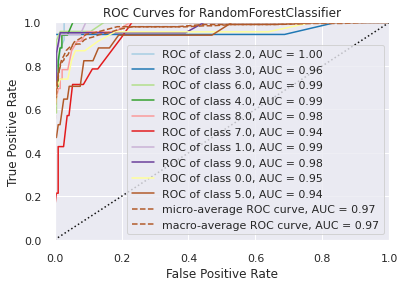

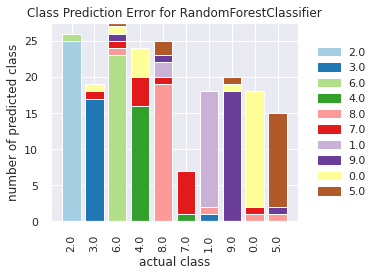

In [104]:
class_vis(RFC_PCA_model, 'RFC_PCA', X_train_PCA, labels_train, 
             X_test_PCA, labels_test)

### Actual Test Data Predictions

In [105]:
submitted(RFC_PCA_model, 'RFC_PCA', test_PCA)

,Label,ImageId
1,2,1
2,0,2
3,9,3
4,4,4
5,2,5
...,...,...
27996,9,27996
27997,7,27997
27998,3,27998
27999,9,27999


## K Means Clustering

In [ ]:
n_digits = len(np.unique(labels_train))
n_digits

10

In [106]:
n_digits = len(np.unique(labels_train))
print(f"Unique digits in labels {n_digits}")

Kmeans_model, Kmeans_rt = run_model(MiniBatchKMeans(n_clusters=n_digits), 'Kmeans', X_train, labels_train, False)
train_pred_Kmeans = prediction(Kmeans_model, X_train)

test_pred_Kmeans = prediction(Kmeans_model, X_test)

Unique digits in labels 10
Kmeans took 0.3493 seconds or 0.0058 minutes to run.


### Kmeans Evaluation

In [107]:
Kmeans_train = evaluating_model(labels_train, train_pred_Kmeans, 'Kmeans', 'Train')
eval_classification(train_pred_Kmeans, labels_train, X_train, 'Kmeans', 'Train')

print("---------------------")
Kmeans_test = evaluating_model(labels_test, test_pred_Kmeans, 'Kmeans', 'Test')
eval_classification(test_pred_Kmeans, labels_test, X_test, 'Kmeans', 'Test')

,model_name,type,metric_name,metric
0,Kmeans,Train,accuracy,0.175
1,Kmeans,Train,f1,0.175
2,Kmeans,Train,recall,0.175
3,Kmeans,Train,precision,0.175



  Kmeans for Train Data
  FPR [0.         0.07479224 0.14265928 0.33379501 0.43213296 0.53047091
 0.58587258 0.71745152 0.78393352 0.86980609 1.        ]
  TPR [0.         0.         0.         0.01282051 0.01282051 0.02564103
 0.02564103 0.02564103 0.98717949 0.98717949 1.        ]
  
---------------------


,model_name,type,metric_name,metric
0,Kmeans,Test,accuracy,0.17
1,Kmeans,Test,f1,0.17
2,Kmeans,Test,recall,0.17
3,Kmeans,Test,precision,0.17



  Kmeans for Test Data
  FPR [0.         0.06043956 0.12087912 0.28021978 0.37362637 0.46703297
 0.53296703 0.6978022  0.78571429 0.85714286 1.        ]
  TPR [0.         0.         0.         0.         0.05555556 0.05555556
 0.05555556 0.05555556 1.         1.         1.        ]
  


### Actual Test Data Predictions

In [108]:
submitted(Kmeans_model, 'Kmeans', test)

,Label,ImageId
1,9,1
2,8,2
3,2,3
4,3,4
5,0,5
...,...,...
27996,7,27996
27997,7,27997
27998,0,27998
27999,7,27999


# Compare Models

In [109]:
def model_comparisons (df, metric, axis):
  grouped_df = model_compare[model_compare['metric_name'] == metric]

  sns.set_style("darkgrid")
  g = sns.barplot(data=grouped_df, hue='type', x='model_name', y='metric', palette='dark', ax=axis)
  g.set_ylabel(metric)
  g.set_title(f'{metric} of Models \nfor Company Bankruptcy')
  g.legend(loc=(0.6,1.15))

  return

In [110]:
model_compare = pd.concat([RFC_train, RFC_test, RFCcv_train, RFCcv_test,
                           RFC_PCA_train, RFC_PCA_test, Kmeans_train, Kmeans_test,
                           RFC_train_prob, RFC_test_prob, RFC_PCA_test_prob,
                           RFC_PCA_train_prob, RFCcv_test, RFCcv_train, RFCcv_test_prob,
                           RFCcv_train_prob])

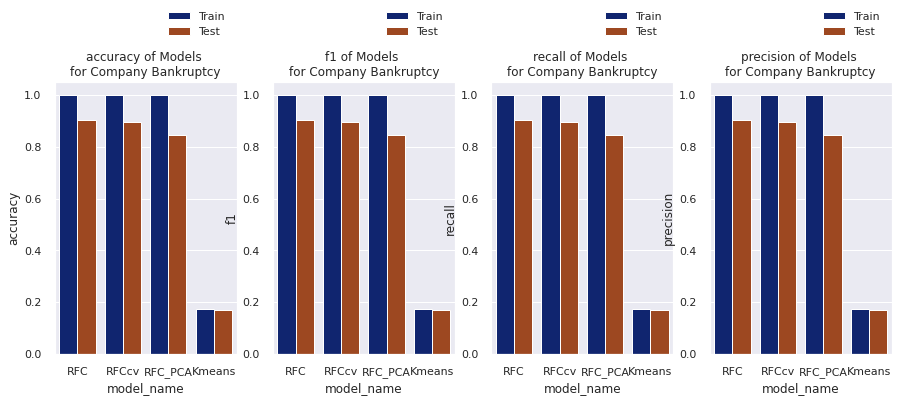

In [112]:
f, (ax0, ax1, ax2, ax3) = plt.subplots(1,4, figsize=(15,5))

model_comparisons(model_compare, 'accuracy', ax0)
model_comparisons(model_compare, 'f1', ax1)
model_comparisons(model_compare, 'recall', ax2)
model_comparisons(model_compare, 'precision', ax3)

f.savefig('accuracy_f1_recall_precision_digits.png')

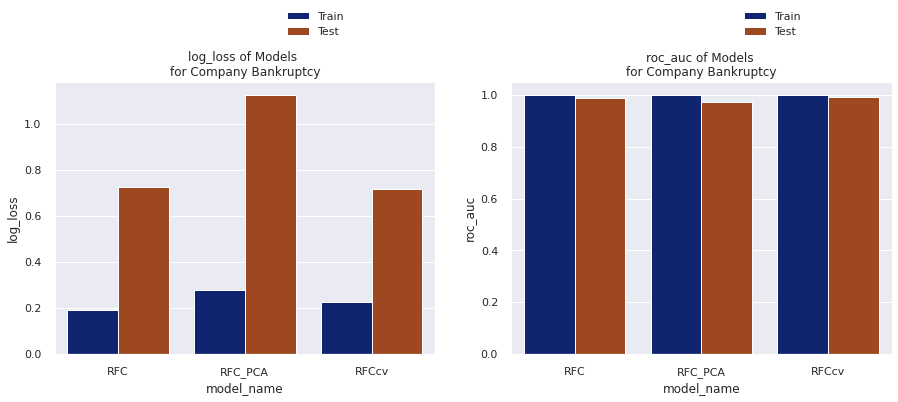

In [113]:
f, (ax0, ax1) = plt.subplots(1,2, figsize=(15,5))

model_comparisons(model_compare, 'log_loss', ax0)
model_comparisons(model_compare, 'roc_auc', ax1)

f.savefig('log_loss__roc_auc_digits.png')